In [2]:
import pandas as pd
import numpy as np
import pyEDM
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [3]:
YOX1 = "YML027W"
YHP1 = "YDR451C"
CLN3 = "YAL040C"

In [53]:
filename = "2090_combined_timeseries.csv"


def load_all():
    df = pd.read_csv(f"../data/{filename}")
    return df


def load_1st_half():
    df = pd.read_csv(f"../data/{filename}")
    df = df.iloc[: df.shape[0] // 2]
    return df


def load_2nd_half():
    df = pd.read_csv(f"../data/{filename}")
    df = df.iloc[df.shape[0] // 2 :]
    return df


df = load_all()

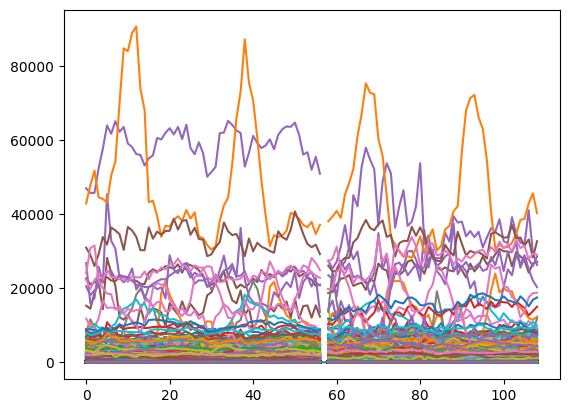

In [54]:
df.plot(legend=False);

In [ ]:
df[df.columns[df.max() > 10]].plot(legend=False)
df[df.columns[df.min() < -10]].plot(legend=False)

In [56]:
mean = df.mean().sort_values()
px.line(x=range(mean.size), y=mean)

In [50]:
std = df.std().sort_values()
px.line(x=range(std.size), y=std)

In [21]:
def interpolate_outliers(df: pd.DataFrame, column: str, threshold: float) -> pd.Series:
    outliers = abs(df[column]) > threshold
    df.loc[outliers, column] = np.nan
    return df[column].interpolate(method="linear")


def smooth(df: pd.DataFrame, column: str, window: int) -> pd.Series:
    return df[column].rolling(window=window).mean()


def scale(df: pd.DataFrame, column: str) -> pd.Series:
    return (df[column] - df[column].min()) / (df[column].max() - df[column].min())


def normalize(df: pd.DataFrame, column: str) -> pd.Series:
    return (df[column] - df[column].mean()) / df[column].std()

In [60]:
def plot_columns(df: pd.DataFrame, columns: list[str]) -> None:
    fig = make_subplots(
        rows=1, cols=len(columns), subplot_titles=columns, shared_yaxes=True
    )

    for i, column in enumerate(columns):
        # sampling interval is 5 minutes
        fig.add_trace(
            go.Scatter(
                x=[v * 5 for v in range(df.shape[0])], y=df[column], name=column
            ),
            row=1,
            col=i + 1,
        )
        fig.update_xaxes(title_text="time (min)", row=1, col=i + 1)
    fig.update_yaxes(title_text="Expression", row=1, col=1)

    fig.update_layout(height=400, width=1000, showlegend=False)
    fig.show()


def plot_embedding2D(df: pd.DataFrame, columns: list[str]) -> None:
    assert len(columns) == 2
    fig = go.Figure(data=go.Scatter(x=df[columns[0]], y=df[columns[1]], mode="lines"))
    fig.update_layout(
        title="2D Embedding Plot",
        xaxis_title=columns[0],
        yaxis_title=columns[1],
        width=500,
        height=400,
    )
    fig.show()


def plot_embedding3D(df: pd.DataFrame, columns: list[str]) -> None:
    assert len(columns) == 3
    fig = go.Figure(
        data=go.Scatter3d(
            x=df[columns[0]], y=df[columns[1]], z=df[columns[2]], mode="lines"
        )
    )
    fig.update_layout(
        title="3D Embedding Plot",
        scene=dict(
            xaxis_title=columns[0], yaxis_title=columns[1], zaxis_title=columns[2]
        ),
        width=600,
        height=600,
    )
    fig.update_layout(scene=dict(camera=dict(eye=dict(x=1.5, y=1.5, z=0.8))))
    fig.show()

In [61]:
df = load_1st_half()

plot_columns(df, [YOX1, YHP1, CLN3])
plot_embedding2D(df, [CLN3, YOX1])
plot_embedding2D(df, [CLN3, YHP1])
plot_embedding3D(df, [YOX1, YHP1, CLN3])

In [63]:
df = load_1st_half()

for column in [YOX1, YHP1, CLN3]:
    df[column] = interpolate_outliers(df, column, 10)
    df[column] = smooth(df, column, 5)

plot_columns(df, [YOX1, YHP1, CLN3])
plot_embedding3D(df, [YOX1, YHP1, CLN3])

In [64]:
df = load_1st_half()

for column in [YOX1, YHP1, CLN3]:
    df[column] = scale(df, column)

plot_columns(df, [YOX1, YHP1, CLN3])
plot_embedding3D(df, [YOX1, YHP1, CLN3])

In [66]:
df = load_1st_half()

In [79]:
PredictIntervalKwargs = {
    "dataFrame": df,
    "lib": f"1 {df.shape[0]//2}",
    "pred": f"{df.shape[0]//2 + 1} {df.shape[0] - 1}",
    "maxTp": 15,
    "E": 3,
    "showPlot": False,
}


def autocorrelation(x, max_lag):
    lags = range(max_lag)
    autocorr = [1] + [np.corrcoef(x[:-lag], x[lag:])[0, 1] for lag in lags[1:]]
    return np.array(autocorr)


tau_range = range(-1, -6, -1)
Tp_range = range(1, PredictIntervalKwargs["maxTp"] + 1)

for gene in [YOX1, YHP1, CLN3]:
    rho = []
    for tau in tau_range:
        result = pyEDM.PredictInterval(columns=gene, tau=tau, **PredictIntervalKwargs)
        rho.append(result["rho"].values)

    Tp, tau = np.meshgrid(Tp_range, tau_range)
    rho = np.array(rho)

    autocorr = autocorrelation(df[gene].values, max_lag=PredictIntervalKwargs["maxTp"])
    autocorr = np.repeat(autocorr.reshape(1, -1), len(tau_range), axis=0)

    fig = go.Figure(
        data=[
            go.Surface(x=Tp, y=tau, z=rho),
            go.Surface(
                x=Tp,
                y=tau,
                z=autocorr,
                name="autocorrelation",
                opacity=0.5,
                showscale=False,
            ),
        ]
    )
    fig.update_layout(
        title=f"Landscape of rho for {gene}",
        scene=dict(xaxis_title="Tp", yaxis_title="tau", zaxis_title="rho"),
        width=800,
        height=600,
    )
    fig.show()

In [80]:
PredictIntervalKwargs = {
  "dataFrame": df,
  "lib": f"1 {df.shape[0]//2}",
  "pred": f"{df.shape[0]//2 + 1} {df.shape[0] - 1}",
  "maxTp": 15,
  "E": 3,
  "tau": -1,
  "showPlot": False
}

Tp = list(Tp_range)

for gene in [YOX1, YHP1, CLN3]:
  autocorr = [1] + [np.corrcoef(df[gene].values[:-lag], df[gene].values[lag:])[0, 1] for lag in Tp[1:]]
  rho = pyEDM.PredictInterval(columns=gene, **PredictIntervalKwargs)["rho"]
  
  fig = go.Figure([
    go.Scatter(x=Tp, y=autocorr, name='Autocorrelation'),
    go.Scatter(x=Tp, y=rho, name='rho')
  ])

  fig.update_layout(
    title=f"Autocorrelation and rho for {gene}",
    xaxis_title="Tp",
    width=800,
    height=600
  )

  fig.show()

In [84]:
Tp = 7

EmbedDimensionKwargs = {
  "dataFrame": df,
  "lib": f"1 {df.shape[0]//2}",
  "pred": f"{df.shape[0]//2 + 1} {df.shape[0] - 1}",
  "maxE": 5,
  "Tp": Tp,
  "showPlot": False
}

for gene in [YOX1, YHP1, CLN3]:
    tau_range = range(-1, -5, -1)
    E_range = range(1, EmbedDimensionKwargs["maxE"] + 1)

    rho = []
    for tau in tau_range:
        result = pyEDM.EmbedDimension(columns=gene, tau=tau, **EmbedDimensionKwargs)
        rho.append(result['rho'].values)

    E, tau = np.meshgrid(E_range, tau_range)
    rho = np.array(rho)

    fig = go.Figure(data=[go.Surface(x=E, y=tau, z=rho)])
    fig.update_layout(
        title=f'Landscape of rho for {gene}',
        scene=dict(
            xaxis_title='E',
            yaxis_title='tau',
            zaxis_title='rho'
        ),
        width=800,
        height=600
    )
    fig.show()

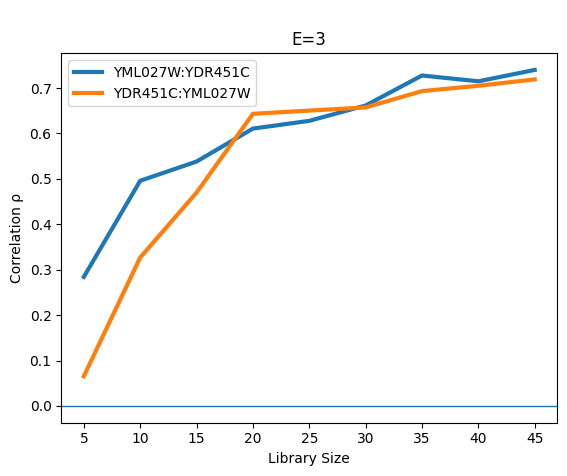

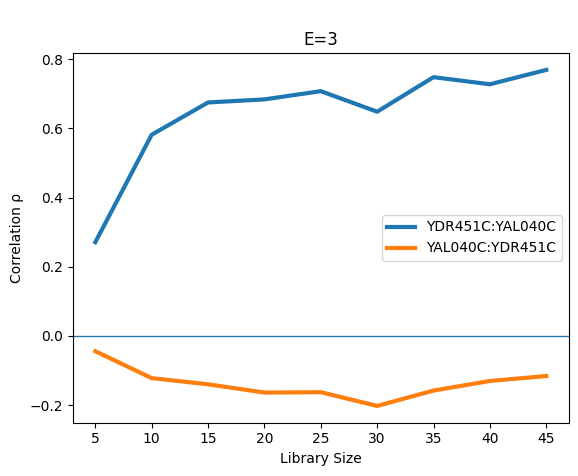

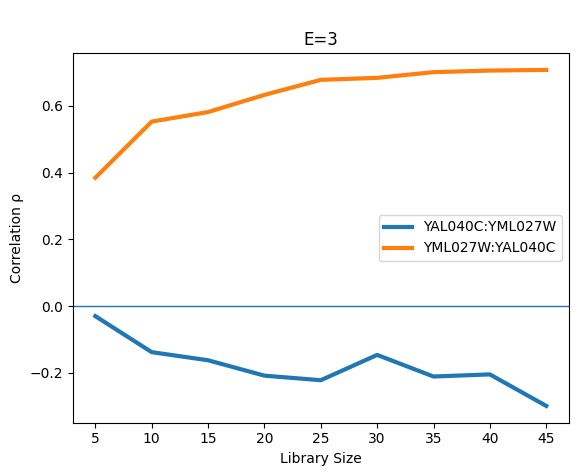

In [87]:
E = 3
tau = -1

CCMKwargs = {
  "dataFrame": df,
  "libSizes": f"{df.shape[0]//10} {df.shape[0]-5} 5",
  "sample": 10,
  "E": E,
  "Tp": Tp,
  "tau": tau,
  "showPlot": True,
}

pairs = [(YOX1, YHP1), (YHP1, CLN3), (CLN3, YOX1)]

for pair in pairs:
    pyEDM.CCM(columns=pair[0], target=pair[1], **CCMKwargs)

In [88]:
def plot_lagged(df: pd.DataFrame, column: str, tau: int) -> None:
    col = df[column].to_numpy()

    fig = go.Figure(data=[go.Scatter3d(
        x=col[:-2*tau],
        y=col[tau:-tau],
        z=col[2*tau:],
        mode='lines',
        line=dict(width=1)
    )])
    fig.update_layout(
        scene=dict(
            xaxis_title="X(t)",
            yaxis_title="X(t-1)",
            zaxis_title="X(t-2)"
        ),
        title=f"Lagged Plot for {column}",
        width=800,
        height=600
    )
    fig.show()

plot_lagged(df, YOX1, 1)

In [ ]:
# Calculate CCM for all pairs
CCMKwargs = {
  "dataFrame": df,
  "libSizes": f"{df.shape[0]//10} {df.shape[0]-5} 5",
  "sample": 10,
  "E": E,
  "Tp": Tp,
  "tau": tau,
  "showPlot": True,
}

